In [1]:
# 0. 사용할 패키지 불러오기
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

from math import sqrt

np.random.seed(5)


# 1. 데이터셋 생성하기
signal_data = pd.read_csv('price_tomato1_B.csv', engine='python', encoding='ms949')
data = signal_data.values
retail_price = data

#std = np.std(df[‘retail_price’].values)

#create_ dataset
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 1:])
        dataY.append(signal_data[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

look_back = 7

#2. 데이터셋 분할
X, Y = create_dataset(data, look_back)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
Y

array([4687., 4687., 4800., ..., 5167., 5167., 5167.])

In [3]:
#기술통계
train_stats = signal_data.describe()
train_stats.pop("date")
train_stats = train_stats.transpose()

train_stats

,count,mean,std,min,25%,50%,75%,max
mean(°C),1428.0,13.590126,10.888134,-14.8,4.375,15.0,23.00,33.7
prep(mm),1428.0,3.065616,11.846932,0.0,0.000,0.0,0.20,144.5
humidity(%),1428.0,57.811975,14.807831,21.8,46.800,57.8,67.65,97.0
whole_price,1428.0,26850.842437,7535.074346,14000.0,20000.000,27000.0,32000.00,48000.0
retail_price,1428.0,4375.577731,1083.337923,2077.0,3560.000,4327.0,5123.00,6967.0


In [4]:
rtp = retail_price[:,-1]
print(rtp)

[4633. 4633. 4633. ... 5167. 5167. 5167.]


In [5]:
std = np.std(rtp)
print(std)

1082.9585366657159


### create dataset을 수행한 뒤 데이터 분할

In [6]:
signal_data.shape

(1428, 6)

In [7]:
# 데이터셋 생성
x_train = X[0:850,]
y_train = Y[0:850,] 

x_val = X[850:1100]
y_val = Y[850:1100]

x_test = X[1100:,]
y_test = Y[1100:,]
y_test_var = y_test


In [8]:
# 2. 모델 구성하기
model = Sequential()
model.add(LSTM(32, input_shape=(7, 5), activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
#model.add(Dropout(0.3))
model.add(Dense(1))


#3. 모델 아키텍쳐 살펴보기
# model.summary()

# 4. 모델 학습과정 설정하기
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
#model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [9]:
#5.모델 학습시키기
#5.1. Early Stopping
callbacks_list = [
    EarlyStopping(
    monitor='val_loss',
    patience=20 ,
    ),
#     ModelCheckpoint(
#     filepath='multi_model.h5',
#     monitor='val_loss',
#     save_best_only = True,
#     )
]

hist = model.fit(x_train, y_train, epochs=500, batch_size=16, callbacks=callbacks_list, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 850 samples, validate on 250 samples
Epoch 1/500





850/850 [==============================] - 4s 5ms/step - loss: 7739188.7879 - mean_absolute_error: 1913.6102 - val_loss: 192699.4890 - val_mean_absolute_error: 348.4295
Epoch 2/500
850/850 [==============================] - 1s 1ms/step - loss: 263739.5667 - mean_absolute_error: 396.5815 - val_loss: 255785.9729 - val_mean_absolute_error: 366.0699
Epoch 3/500
850/850 [==============================] - 1s 1ms/step - loss: 229600.0505 - mean_absolute_error: 370.1705 - val_loss: 257566.0756 - val_mean_absolute_error: 366.5221
Epoch 4/500
850/850 [==============================] - 1s 1ms/step - loss: 228897.7377 - mean_absolute_error: 368.8346 - val_loss: 278668.4012 - val_mean_absolute_error: 382.1011
Epoch 5/500
850/850 [==============================] - 1s 1ms/step - loss: 229900.0519 - mean_absolute_error: 369.1191 - val_loss: 241

Epoch 36/500
850/850 [==============================] - 1s 1ms/step - loss: 230424.0019 - mean_absolute_error: 369.3858 - val_loss: 300264.2059 - val_mean_absolute_error: 396.3294


In [10]:
# 6. 모델 평가하기
scores = model.evaluate(x_test, y_test)

print("%s: %.2f" %(model.metrics_names[1], scores[1]))

321/321 [==============================] - 0s 196us/step
mean_absolute_error: 270.41


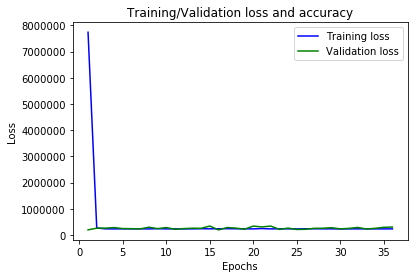

In [11]:
#6.1. epoch, loss 그래프
loss = hist.history['loss']
val_loss = hist.history['val_loss']


epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')

plt.title('Training/Validation loss and accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# 6.2. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  [230810.3206617647, 372.32319896024813]
Validataion Score:  [300264.18325, 396.32941662597653]
Test Score:  [136203.8463632934, 270.4111328125]


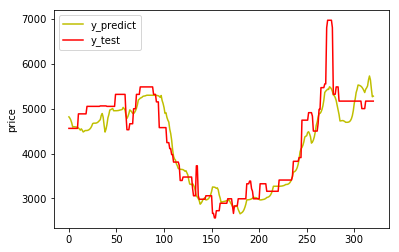

In [13]:
def show_diff(y_predict, y_label, y_test, y_test_label, y_value):

    fig, predict_ax=plt.subplots()

    predict_ax.plot(y_predict, 'y', label=y_label)

    predict_ax.plot(y_test, 'r', label=y_test_label)

    predict_ax.set_ylabel(y_value)

    predict_ax.legend(loc = 'upper left')

    plt.show()
    
#7 예측하기

y_predict = model.predict(x_test).flatten()

show_diff(y_predict, 'y_predict', y_test, 'y_test', 'price')

In [14]:
# 데이터 저장
df = pd.DataFrame(y_predict)
df.insert(0,'y_test',y_test_var)
df = df.rename(columns = {0: 'y_predict'})
df.to_csv('predict_tomatobusan.csv', index=False)

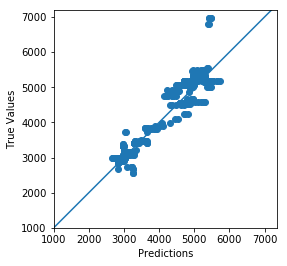

In [15]:

test_predictions = y_test

plt.scatter(y_predict, y_test)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.axis('equal')
plt.axis('square')
plt.xlim([1000,plt.xlim()[1]])
plt.ylim([1000,plt.ylim()[1]])
_ = plt.plot([-100000, 100000], [-100000, 100000])


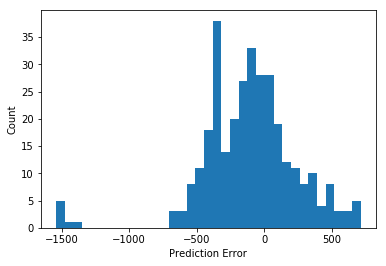

In [16]:
#오차의 분포
error = y_predict - y_test
plt.hist(error, bins = 35)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [17]:
rmse = sqrt(mean_squared_error(y_predict,y_test))
print("RMSE: {:.2f}".format(rmse))

RMSE: 369.06


In [18]:
print("STD: {:.2f}".format(std))

STD: 1082.96
